In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#from matplotlib import animation

/home/jonat/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [66]:
m1 = 1
m2 = 1
m3 = 1
m4 = 1
m5 = 10
l1 = 1
l2 = 1
l3 = 1
l4 = 1
g = 9.81

dt = 0.01
tf = 20
t = np.arange(0, tf, dt)

Q_0 = np.array([[0, 0], [0, 0], [0, 0], [0, 0], [1, 0]])
Q_dot_0 = np.array([[0, 0], [0, 0], [0, 0], [0, 0], [0, 0]])

M = np.diag([m1, m2, m3, m4, m5])
M_inv = np.linalg.inv(M)
G = np.array([[0, g], [0, g], [0, g], [0, g], [0, g]])
D_of_G = np.array([[ 1,  0,  0,  0],
                   [ 0,  1,  0,  0],
                   [ 0,  0,  1,  0],
                   [ 0,  0,  0,  1],
                   [-1, -1, -1, -1]])
edge_laplacian = D_of_G.T@M_inv@D_of_G

# Edge Control
k1 = 10
k2 = 10

theta_d = lambda t: np.pi/4*np.cos(np.pi/4*t)
theta_d_dot = lambda t: -np.pi**2/16*np.sin(np.pi/4*t)
theta_d_ddot = lambda t: -np.pi**3/64*np.cos(np.pi/4*t)
Qed = lambda t: np.array([[l1*np.cos(theta_d(t)), l1*np.sin(theta_d(t))],
                          [-l2*np.cos(theta_d(t)), l2*np.sin(theta_d(t))],
                          [-l3*np.cos(theta_d(t)), -l3*np.sin(theta_d(t))],
                          [l4*np.cos(theta_d(t)), -l4*np.sin(theta_d(t))]])
Qed_dot = lambda t: np.array([[-l1*np.sin(theta_d(t))*theta_d_dot(t), l1*np.cos(theta_d(t))*theta_d_dot(t)],
                              [l2*np.sin(theta_d(t))*theta_d_dot(t), l2*np.cos(theta_d(t))*theta_d_dot(t)],
                              [l3*np.sin(theta_d(t))*theta_d_dot(t), -l3*np.cos(theta_d(t))*theta_d_dot(t)],
                              [-l4*np.sin(theta_d(t))*theta_d_dot(t), -l4*np.cos(theta_d(t))*theta_d_dot(t)]])
Qed_ddot = lambda t: np.array([[-l1*np.cos(theta_d(t))*theta_d_dot(t)**2-l1*np.sin(theta_d(t))*theta_d_ddot(t), l1*np.sin(theta_d(t))*theta_d_dot(t)**2-l1*np.cos(theta_d(t))*theta_d_ddot(t)], # Unckecked!
                               [l2*np.cos(theta_d(t))*theta_d_dot(t)**2+l2*np.sin(theta_d(t))*theta_d_ddot(t), -l2*np.sin(theta_d(t))*theta_d_dot(t)**2-l2*np.cos(theta_d(t))*theta_d_ddot(t)],
                               [l3*np.cos(theta_d(t))*theta_d_dot(t)**2+l3*np.sin(theta_d(t))*theta_d_ddot(t), -l3*np.sin(theta_d(t))*theta_d_dot(t)**2+l3*np.cos(theta_d(t))*theta_d_ddot(t)],
                               [-l4*np.cos(theta_d(t))*theta_d_dot(t)**2-l4*np.sin(theta_d(t))*theta_d_ddot(t), l4*np.sin(theta_d(t))*theta_d_dot(t)**2+l4*np.cos(theta_d(t))*theta_d_ddot(t)]])

R90 = np.array([[0, -1],
                [1, 0]])

# Node Control
k3 = 1
k4 = 1
r5d = lambda t: np.array([0, 0])
r5d_dot = lambda t: np.array([0, 0])
r5d_ddot = lambda t: np.array([0, 0])

def ODE(t, y):
    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x1_dot, y1_dot, x2_dot, y2_dot, x3_dot, y3_dot, x4_dot, y4_dot, x5_dot, y5_dot = y

    Q = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4], [x5, y5]])
    Q_dot = np.array([[x1_dot, y1_dot], [x2_dot, y2_dot], [x3_dot, y3_dot], [x4_dot, y4_dot], [x5_dot, y5_dot]])
    Qe = D_of_G.T@Q
    Qe_dot = D_of_G.T@Q_dot

    r1e = Qe[0, :]
    r2e = Qe[1, :]
    r3e = Qe[2, :]
    r4e = Qe[3, :]

    temp = np.linalg.inv(np.multiply(edge_laplacian, Qe@Qe.T))
    lambda_simplified = temp @ (Qe_dot@Qe_dot.T).diagonal()
    Lambda_simplified = np.diag(lambda_simplified)
    Fe = -k1*(Qe-Qed(t)) - k2*(Qe_dot-Qed_dot(t)) + Qed_ddot(t) + edge_laplacian@Lambda_simplified@Qe

    a1 = R90@r1e/l1
    b1 = Fe[0, :]
    v1 = a1.dot(b1)
    u1 = v1*m1

    a2 = R90@r2e/l2
    b2 = Fe[1, :]
    v2 = a2.dot(b2)
    u2 = v2*m2

    a3 = R90@r3e/l3
    b3 = Fe[2, :]
    v3 = a3.dot(b3)
    u3 = v3*m3

    a4 = R90@r4e/l4
    b4 = Fe[3, :]
    v4 = a4.dot(b4)
    u4 = v4*m4

    r5 = Q[4, :]
    r5_dot = Q_dot[4, :]

    F = np.array([u1*a1 + m1*np.array([0, g]),
                  u2*a2 + m2*np.array([0, g]),
                  u3*a3 + m3*np.array([0, g]),
                  u4*a4 + m4*np.array([0, g]),
                  m5*(-k3*(r5-r5d(t)) - k4*(r5_dot-r5d_dot(t)) + r5d_ddot(t)) + m5*np.array([0, g])])
    
    lambda_full = temp @ (D_of_G.T@M_inv@F@Qe.T + Qe_dot@Qe_dot.T).diagonal()
    Lambda_full = np.diag(lambda_full)
    Q_ddot = -G + M_inv@(F - D_of_G@Lambda_full@Qe)
    
    x1_ddot = Q_ddot[0, 0]
    y1_ddot = Q_ddot[0, 1]
    x2_ddot = Q_ddot[1, 0]
    y2_ddot = Q_ddot[1, 1]
    x3_ddot = Q_ddot[2, 0]
    y3_ddot = Q_ddot[2, 1]
    x4_ddot = Q_ddot[3, 0]
    y4_ddot = Q_ddot[3, 1]
    x5_ddot = Q_ddot[4, 0]
    y5_ddot = Q_ddot[4, 1]
    
    return (x1_dot, y1_dot, x2_dot, y2_dot, x3_dot, y3_dot, x4_dot, y4_dot, x5_dot, y5_dot, x1_ddot, y1_ddot, x2_ddot, y2_ddot, x3_ddot, y3_ddot, x4_ddot, y4_ddot, x5_ddot, y5_ddot)

sol = solve_ivp(ODE, (0, tf), (Q_0[0, 0], Q_0[0, 1], Q_0[1, 0], Q_0[1, 1], Q_0[2, 0], Q_0[2, 1], Q_0[3, 0], Q_0[3, 1], Q_0[4, 0], Q_0[4, 1], Q_dot_0[0, 0], Q_dot_0[0, 1], Q_dot_0[1, 0], Q_dot_0[1, 1], Q_dot_0[2, 0], Q_dot_0[2, 1], Q_dot_0[3, 0], Q_dot_0[3, 1], Q_dot_0[4, 0], Q_dot_0[4, 1]), t_eval=t, method="DOP853", rtol=1e-10, atol=1e-10)
x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x1_dot, y1_dot, x2_dot, y2_dot, x3_dot, y3_dot, x4_dot, y4_dot, x5_dot, y5_dot = sol.y

Q = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4], [x5, y5]])
Qe = np.moveaxis(np.array([D_of_G.T@Q[:, :, i] for i in range(len(t))]), 0, -1)

In [44]:
f1x = np.zeros_like(t)
f1y = np.zeros_like(t)
f2x = np.zeros_like(t)
f2y = np.zeros_like(t)
f3x = np.zeros_like(t)
f3y = np.zeros_like(t)
for i in range(len(t)):
    f1x[i] = f1_expr(q1x[i], q1y[i], q2x[i], q2y[i], q3x[i], q3y[i], q1x_dot[i], q1y_dot[i], q2x_dot[i], q2y_dot[i], q3x_dot[i], q3y_dot[i], m1, m2, m3, l1, l2, g, t[i])[0, 0]
    f1y[i] = f1_expr(q1x[i], q1y[i], q2x[i], q2y[i], q3x[i], q3y[i], q1x_dot[i], q1y_dot[i], q2x_dot[i], q2y_dot[i], q3x_dot[i], q3y_dot[i], m1, m2, m3, l1, l2, g, t[i])[1, 0]
    f2x[i] = f2_expr(q2x[i], q2y[i], q2x_dot[i], q2y_dot[i], m1, m2, m3, l1, l2, g, t[i])[0, 0]
    f2y[i] = f2_expr(q2x[i], q2y[i], q2x_dot[i], q2y_dot[i], m1, m2, m3, l1, l2, g, t[i])[1, 0]
    f3x[i] = f3_expr(q1x[i], q1y[i], q2x[i], q2y[i], q3x[i], q3y[i], q1x_dot[i], q1y_dot[i], q2x_dot[i], q2y_dot[i], q3x_dot[i], q3y_dot[i], m1, m2, m3, l1, l2, g, t[i])[0, 0]
    f3y[i] = f3_expr(q1x[i], q1y[i], q2x[i], q2y[i], q3x[i], q3y[i], q1x_dot[i], q1y_dot[i], q2x_dot[i], q2y_dot[i], q3x_dot[i], q3y_dot[i], m1, m2, m3, l1, l2, g, t[i])[1, 0]

Text(0.5, 1.0, '$x_1-x_2$')

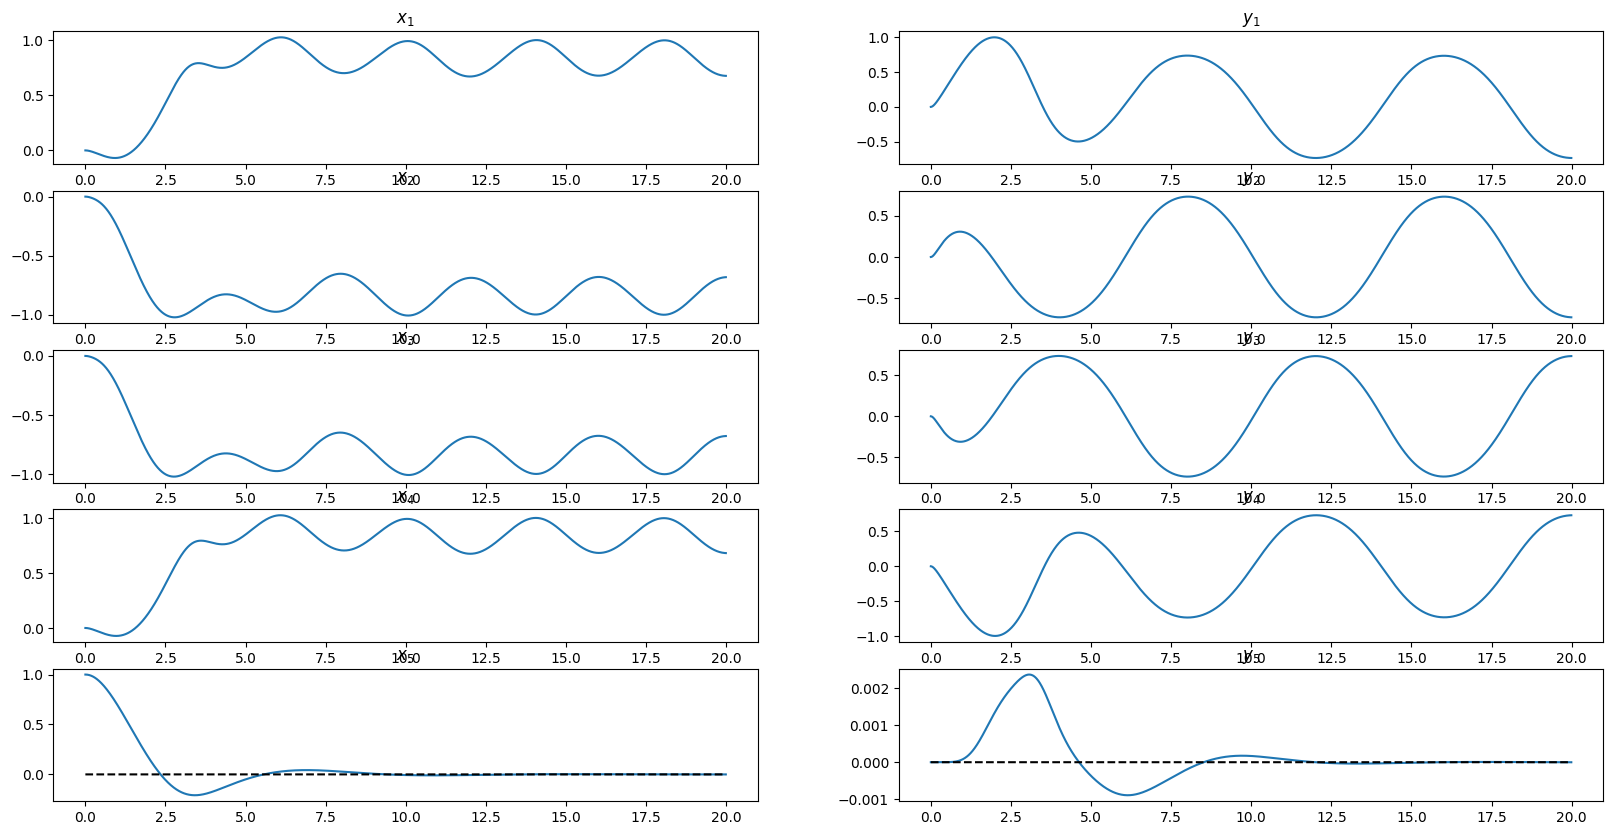

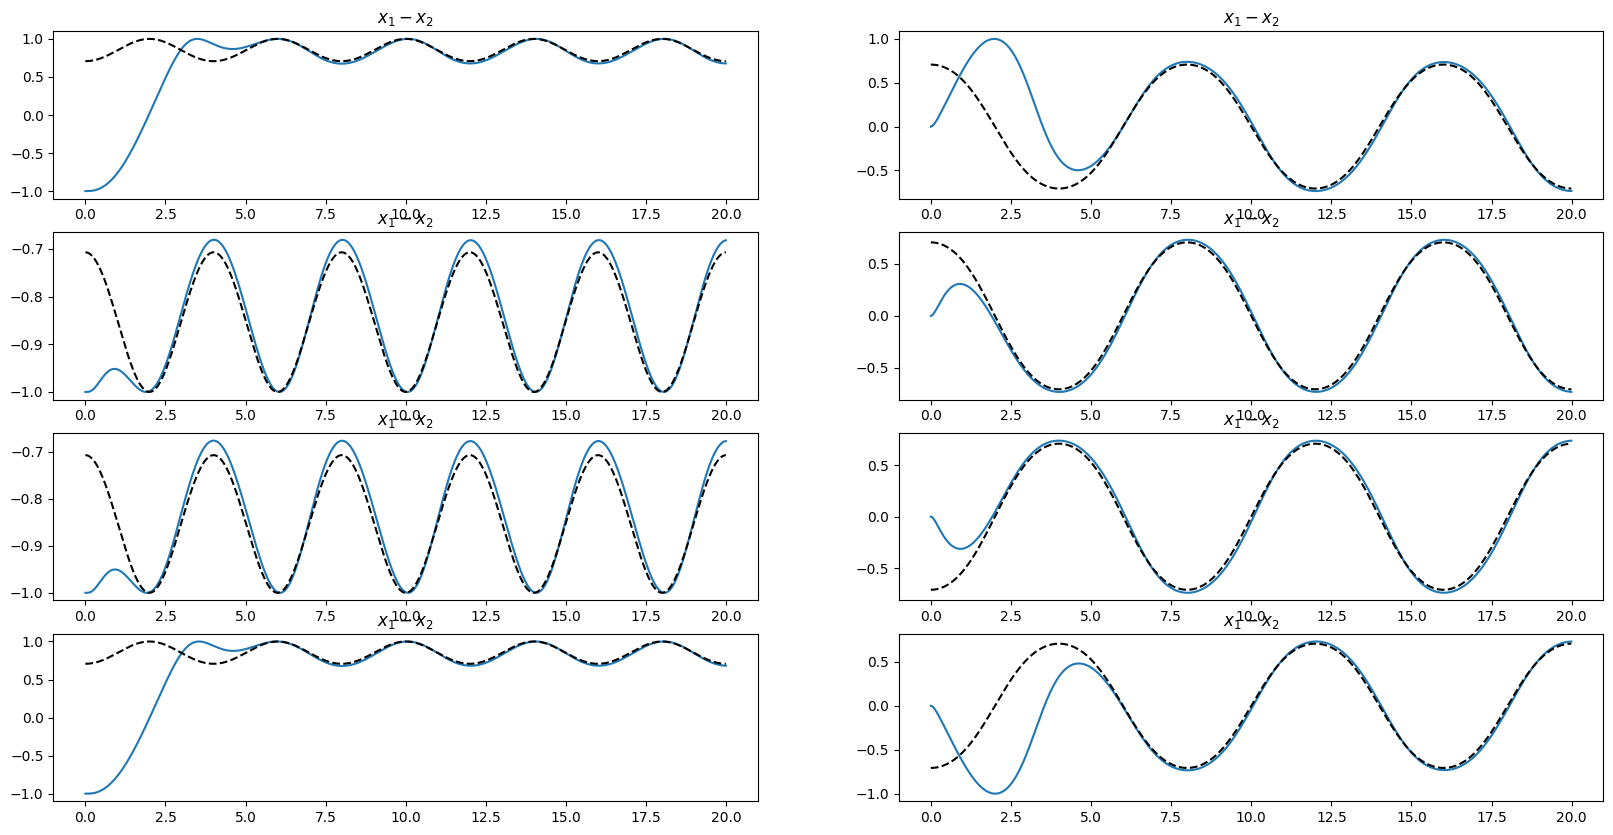

In [68]:
# Nodes
plt.figure(figsize=(20, 10))
plt.subplot(5, 2, 1)
plt.plot(t, x1, label='x1')
plt.title('$x_1$')

plt.subplot(5, 2, 2)
plt.plot(t, y1, label='y1')
plt.title('$y_1$')

plt.subplot(5, 2, 3)
plt.plot(t, x2, label='x2')
plt.title('$x_2$')

plt.subplot(5, 2, 4)
plt.plot(t, y2, label='y2')
plt.title('$y_2$')

plt.subplot(5, 2, 5)
plt.plot(t, x3, label='x3')
plt.title('$x_3$')

plt.subplot(5, 2, 6)
plt.plot(t, y3, label='y3')
plt.title('$y_3$')

plt.subplot(5, 2, 7)
plt.plot(t, x4, label='x4')
plt.title('$x_4$')

plt.subplot(5, 2, 8)
plt.plot(t, y4, label='y4')
plt.title('$y_4$')

plt.subplot(5, 2, 9)
plt.plot(t, x5, label='x5')
plt.plot(t, np.zeros(len(t)), color='black', linestyle='--')
plt.title('$x_5$')

plt.subplot(5, 2, 10)
plt.plot(t, y5, label='y5')
plt.plot(t, np.zeros(len(t)), color='black', linestyle='--')
plt.title('$y_5$')

# Edges
plt.figure(figsize=(20, 10))
plt.subplot(4, 2, 1)
plt.plot(t, Qe[0, 0, :])
plt.plot(t, Qed(t)[0, 0], color='black', linestyle='--')
plt.title('$x_1-x_2$')

plt.subplot(4, 2, 2)
plt.plot(t, Qe[0, 1, :])
plt.plot(t, Qed(t)[0, 1], color='black', linestyle='--')
plt.title('$x_1-x_2$')

plt.subplot(4, 2, 3)
plt.plot(t, Qe[1, 0, :])
plt.plot(t, Qed(t)[1, 0], color='black', linestyle='--')
plt.title('$x_1-x_2$')

plt.subplot(4, 2, 4)
plt.plot(t, Qe[1, 1, :])
plt.plot(t, Qed(t)[1, 1], color='black', linestyle='--')
plt.title('$x_1-x_2$')

plt.subplot(4, 2, 5)
plt.plot(t, Qe[2, 0, :])
plt.plot(t, Qed(t)[2, 0], color='black', linestyle='--')
plt.title('$x_1-x_2$')

plt.subplot(4, 2, 6)
plt.plot(t, Qe[2, 1, :])
plt.plot(t, Qed(t)[2, 1], color='black', linestyle='--')
plt.title('$x_1-x_2$')

plt.subplot(4, 2, 7)
plt.plot(t, Qe[3, 0, :])
plt.plot(t, Qed(t)[3, 0], color='black', linestyle='--')
plt.title('$x_1-x_2$')

plt.subplot(4, 2, 8)
plt.plot(t, Qe[3, 1, :])
plt.plot(t, Qed(t)[3, 1], color='black', linestyle='--')
plt.title('$x_1-x_2$')

# # Theta
# plt.figure()
# plt.plot(t, ((q1x-q2x)*(q2x-q3x)+(q1y-q2y)*(q2y-q3y))/(l1*l2), label=r'$\cos\theta$')
# #plt.axhline(Qed_val[0, :].dot(Qed_val[1, :])/(l1*l2), color='black', linestyle='--', label=r'$\cos\theta_{d}$')
# plt.title(r'$\cos\theta$')
# plt.legend()
# #plt.gca().set_ylim(-1.01, -0.99)

# # Forces
# plt.figure()
# plt.plot(t, np.linalg.norm(np.array([f1x, f1y]), axis=0))
# plt.plot(t, np.linalg.norm(np.array([f2x, f2y]), axis=0))
# plt.plot(t, np.linalg.norm(np.array([f3x, f3y]), axis=0))
# plt.title('Forces')
# #plt.legend()
# #plt.gca().set_ylim(-10, 10)